# Stock Price Prediction — Amazon (AMZN)

## Notebook 2 — Model Development (ARIMA, SARIMAX, GARCH)

## Objective

The purpose of this notebook is to:

1. Prepare the modeling dataset using returns as the target variable.
2. Split the data chronologically into training and testing sets.
3. Build and evaluate time-series forecasting models:
   - ARIMA (baseline univariate model),
   - SARIMAX (including S&P 500 as an exogenous variable),
   - GARCH(1,1) (conditional volatility modeling).
4. Compare model performance using out-of-sample **t+1 rolling forecasts**.
5. Analyze forecast behavior during normal and stress periods.

## Modeling Strategy

Based on the exploratory analysis in Notebook 1:

- Raw prices were found to be non-stationary.
- Returns were stationary (ADF test).
- Returns exhibit little autocorrelation, consistent with financial theory.
- Volatility clustering was detected in squared returns.
- Amazon shows a time-varying correlation with the S&P 500.

Therefore:

- We model **daily returns** rather than raw prices.
- The target variable is **the return at t+1**, predicted using all information available up to t.
- ARIMA will serve as a baseline model.
- SARIMAX will incorporate S&P 500 returns as an external market factor.
- GARCH will model conditional volatility dynamics.

## Forecasting Approach: Rolling t+1

All models use a **rolling one-step-ahead forecast** strategy:
- At each time step t, the model is trained on all data available up to t,
- It predicts only the next observation at t+1,
- The true value at t+1 is then added to the history before moving to t+2.

This strictly avoids look-ahead bias and simulates real-world forecasting conditions.

## Important Note on Data Leakage

All train/test splits are strictly chronological to preserve the time-series structure and avoid look-ahead bias.

## 1. Data Loading

We load the cleaned dataset produced in Notebook 1.

This dataset already includes:
- Adjusted Close price,
- Daily returns,
- S&P 500 returns (exogenous variable),
- Trading volume.

No additional transformations are performed at this stage to avoid data leakage.

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

data = pd.read_csv("../data/raw/amzn_sp500_clean.csv", index_col=0, parse_dates=True)

print(data.shape)
print("Columns:", list(data.columns))
data.head(3)

(5012, 18)
Columns: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Price', 'Return', 'SP500_Return', 'DayOfWeek', 'Month', 'Return_lag1', 'Return_lag2', 'Return_lag5', 'Vol_5d', 'Vol_20d', 'LogVolume', 'SP500_Return_lag1']


,Adj Close,Close,High,Low,Open,Volume,Price,Return,SP500_Return,DayOfWeek,Month,Return_lag1,Return_lag2,Return_lag5,Vol_5d,Vol_20d,LogVolume,SP500_Return_lag1
Date,,,,,,,,,,,,,,,,,,
2005-02-02,2.0940,2.0940,2.1770,2.0430,2.1525,526472000,2.0940,-0.014124,0.003178,2,2,-0.017122,0.023685,0.009770,0.017471,0.024094,20.081709,0.006891
2005-02-03,1.7875,1.7875,1.7945,1.7265,1.7450,1210372000,1.7875,-0.146371,-0.002766,3,2,-0.014124,-0.017122,0.023464,0.019816,0.021097,20.914194,0.003178
2005-02-04,1.7860,1.7860,1.7990,1.7595,1.7825,346094000,1.7860,-0.000839,0.011043,4,2,-0.146371,-0.014124,-0.002127,0.066355,0.038953,19.662221,-0.002766


In [105]:
data.info()
data[["Return", "SP500_Return"]].describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5012 entries, 2005-02-02 to 2024-12-31
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Adj Close          5012 non-null   float64
 1   Close              5012 non-null   float64
 2   High               5012 non-null   float64
 3   Low                5012 non-null   float64
 4   Open               5012 non-null   float64
 5   Volume             5012 non-null   int64  
 6   Price              5012 non-null   float64
 7   Return             5012 non-null   float64
 8   SP500_Return       5012 non-null   float64
 9   DayOfWeek          5012 non-null   int64  
 10  Month              5012 non-null   int64  
 11  Return_lag1        5012 non-null   float64
 12  Return_lag2        5012 non-null   float64
 13  Return_lag5        5012 non-null   float64
 14  Vol_5d             5012 non-null   float64
 15  Vol_20d            5012 non-null   float64
 16  LogVol

,Return,SP500_Return
count,5012.000000,5012.000000
mean,0.001208,0.000392
std,0.023882,0.012094
min,-0.218220,-0.119841
25%,-0.009840,-0.004076
50%,0.000659,0.000716
75%,0.012349,0.005722
max,0.269497,0.115800


## 2. Train–Test Split (Chronological)

In time-series forecasting, data must be split chronologically to preserve temporal ordering.

We define:

- Training set: 2005–2016
- Test set: 2017–2024  

This setup simulates a real forecasting scenario, where models are trained on historical data and evaluated on future unseen data.

No random shuffling is applied to avoid look-ahead bias.

### Structural Regimes Consideration

Financial markets are known to experience structural breaks and regime shifts (e.g., the 2008 financial crisis, the COVID-19 crash, and the 2022 monetary tightening cycle).  
While formal break tests are not conducted in this project, we acknowledge that model performance may vary across different market regimes.

For this reason, the dataset is split chronologically to simulate real-world forecasting conditions and to evaluate model robustness during both normal and stress periods.

In [106]:
split_date = "2017-01-01"

train = data.loc[data.index < split_date]
test  = data.loc[data.index >= split_date]

y_train = train["Return"]
y_test  = test["Return"]

X_train = train[["SP500_Return"]]
X_test  = test[["SP500_Return"]]

print("Train shape:", train.shape, f"({train.index[0].date()} → {train.index[-1].date()})")
print("Test shape :", test.shape,  f"({test.index[0].date()} → {test.index[-1].date()})")

Train shape: (3000, 18) (2005-02-02 → 2016-12-30)
Test shape : (2012, 18) (2017-01-03 → 2024-12-31)


The split date is set to January 1st, 2017.

This choice ensures that:

- The training set (2005–2016) includes multiple market regimes, such as the 2008 financial crisis and the subsequent recovery period.
- The test set (2017–2024) contains more recent and challenging environments, including the COVID-19 crash (2020) and the 2022 monetary tightening cycle.

This setup allows the model to be trained on diverse historical conditions while being evaluated on structurally different and more volatile recent periods, providing a realistic and rigorous out-of-sample assessment.

## 3. Baseline Model — ARIMA (Univariate)

We start with a univariate ARIMA model on **AMZN daily returns**.

ARIMA models the conditional mean dynamics of the series using:
- **AR (p)**: dependence on past returns,
- **I (d)**: differencing to ensure stationarity,
- **MA (q)**: dependence on past forecast errors.

Since returns were found to be stationary in Notebook 1 (ADF test), we set **d = 0** and focus on selecting **p** and **q**.

### In-sample fit

We first fit the model on the training set to inspect coefficients and residual diagnostics, before running the rolling forecast.

In [107]:
from statsmodels.tsa.arima.model import ARIMA

p, d, q = 1, 0, 1
arima_fit = ARIMA(y_train, order=(p, d, q)).fit()
print(arima_fit.summary())

C:\Users\elise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\elise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\elise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

                               SARIMAX Results                                
Dep. Variable:                 Return   No. Observations:                 3000
Model:                 ARIMA(1, 0, 1)   Log Likelihood                6722.712
Date:                Sat, 28 Feb 2026   AIC                         -13437.424
Time:                        23:33:25   BIC                         -13413.399
Sample:                             0   HQIC                        -13428.782
                               - 3000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      2.610      0.009       0.000       0.002
ar.L1         -0.1149      1.961     -0.059      0.953      -3.958       3.728
ma.L1          0.1230      1.958      0.063      0.9

### ARIMA — Residual Diagnostics

We inspect the residuals to verify:
- No remaining autocorrelation (the model has captured all linear structure),
- Distribution of residuals,
- Presence of heteroskedasticity (volatility clustering).

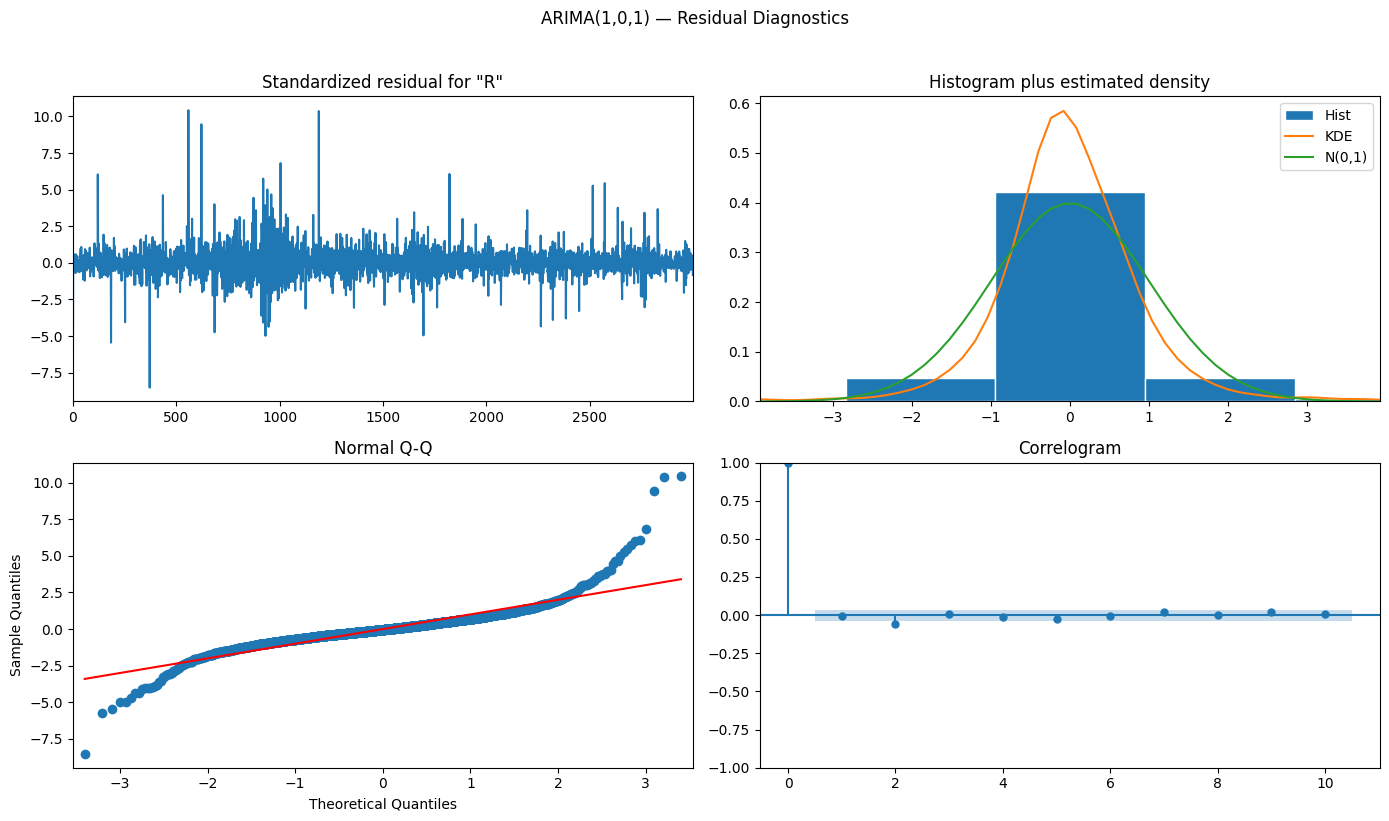

In [108]:
arima_fit.plot_diagnostics(figsize=(14, 8))
plt.suptitle("ARIMA(1,0,1) — Residual Diagnostics", y=1.02)
plt.tight_layout()
plt.show()

The ARIMA(1,0,1) model confirms that past returns do not significantly explain future returns, as AR and MA terms are not statistically significant.

Residual diagnostics indicate:
- No remaining autocorrelation (Ljung-Box test),
- Non-normal residuals (heavy tails),
- Presence of heteroskedasticity (volatility clustering).

These findings motivate extending the model by incorporating exogenous market information (S&P 500 returns) and potentially modeling conditional volatility.

### ARIMA — Rolling t+1 Forecast

We use statsmodels' `.apply()` method to produce rolling one-step-ahead forecasts efficiently.

`.apply()` updates the model state with each new observation without re-fitting from scratch at every step, producing equivalent results to a full rolling re-fit but in a fraction of the time.

`fittedvalues[t]` represents the one-step-ahead prediction for t made at t-1, so we shift by 1 to align predictions with the correct forecast horizon.

In [109]:
# Apply trained model to test set — fast rolling t+1 forecast
arima_applied  = arima_fit.apply(y_test)

# fittedvalues[t] = prediction made at t-1 for t → already t+1 forecasts
arima_forecast = pd.Series(
    arima_applied.fittedvalues.values,
    index=y_test.index,
    name="ARIMA_Forecast"
)

print("ARIMA rolling forecast complete.")
arima_forecast.head()

ARIMA rolling forecast complete.


C:\Users\elise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\elise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\elise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

Date
2017-01-03    0.001279
2017-01-04    0.001309
2017-01-05    0.001302
2017-01-06    0.001515
2017-01-09    0.001401
Name: ARIMA_Forecast, dtype: float64

## 4. Extended Model — SARIMAX (with S&P 500 as Exogenous Variable)

To incorporate broader market information, we extend the ARIMA model by including S&P 500 daily returns as an exogenous variable.

The rationale is that Amazon is part of the S&P 500 index, and its returns are likely influenced by overall market movements (systematic risk / beta effect).

The SARIMAX model allows us to estimate:
- AR and MA dynamics (if any),
- The impact of contemporaneous market returns,
- While preserving the time-series structure.

### Note on the exogenous variable at t+1

For the rolling t+1 forecast with SARIMAX, the S&P 500 return at t+1 is used as the exogenous input. This assumes that the market return is observed simultaneously — a standard assumption when using market indices as contemporaneous regressors.

### In-sample fit

In [110]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

print("Missing values in X_train:", X_train.isna().sum().to_dict())

sarimax_fit = SARIMAX(
    y_train,
    exog=X_train,
    order=(p, d, q),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(sarimax_fit.summary())

C:\Users\elise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\elise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Missing values in X_train: {'SP500_Return': 0}
                               SARIMAX Results                                
Dep. Variable:                 Return   No. Observations:                 3000
Model:               SARIMAX(1, 0, 1)   Log Likelihood                7261.008
Date:                Sat, 28 Feb 2026   AIC                         -14514.017
Time:                        23:33:26   BIC                         -14489.994
Sample:                             0   HQIC                        -14505.376
                               - 3000                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
SP500_Return     1.1313      0.025     44.438      0.000       1.081       1.181
ar.L1           -0.0067      0.209     -0.032      0.974      -0.416       0.4

### SARIMAX — Residual Diagnostics

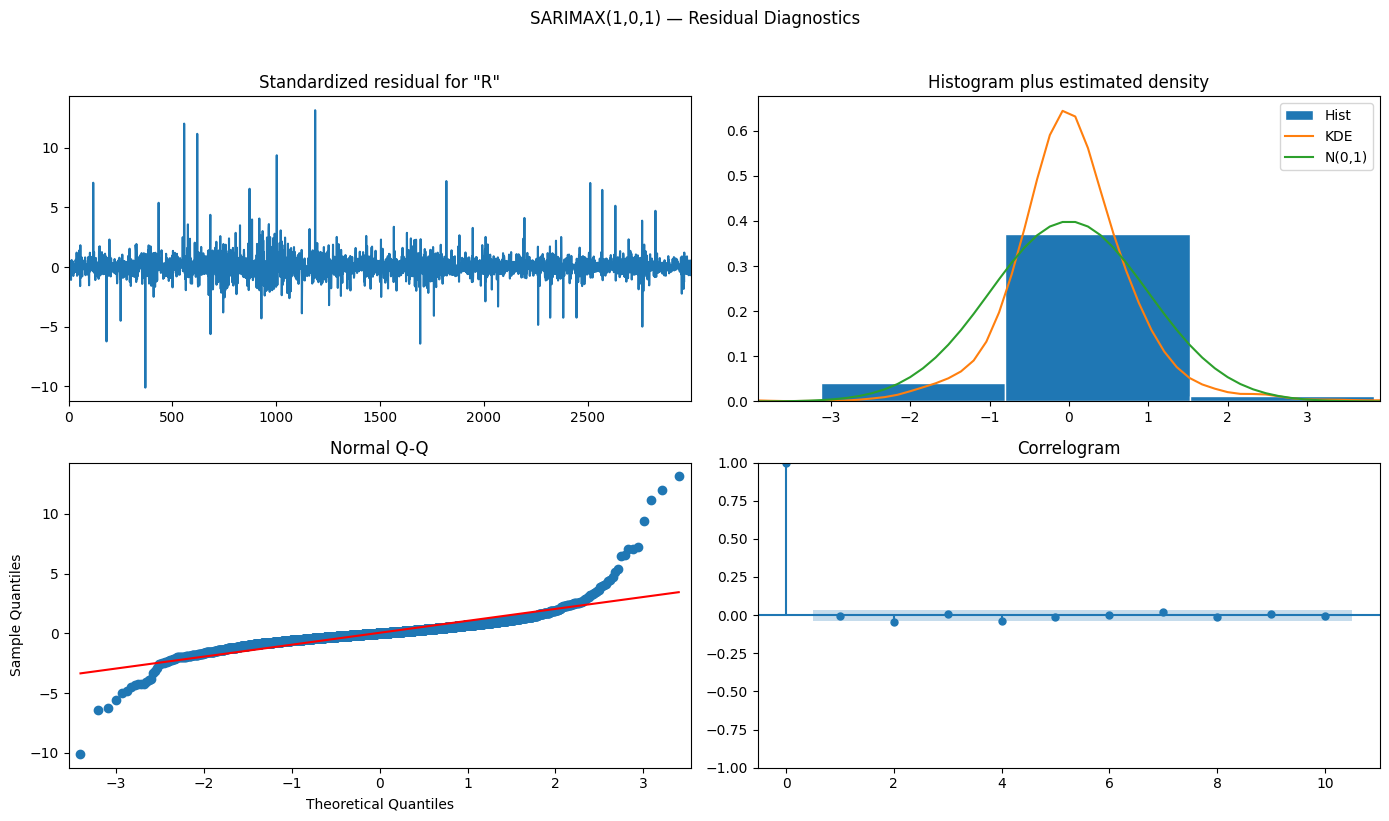

In [111]:
sarimax_fit.plot_diagnostics(figsize=(14, 8))
plt.suptitle("SARIMAX(1,0,1) — Residual Diagnostics", y=1.02)
plt.tight_layout()
plt.show()

The SARIMAX results show that S&P 500 returns have a strong and statistically significant effect on Amazon returns (β ≈ 1.13, p < 0.001).

This confirms that Amazon's return dynamics are largely driven by broader market movements (systematic risk).

Unlike the pure ARIMA model, AR and MA terms become statistically significant once the market effect is controlled for, suggesting residual short-term dynamics.

However, heteroskedasticity remains present in the residuals, indicating volatility clustering that will be addressed by the GARCH model.

### SARIMAX — Rolling t+1 Forecast

Same `.apply()` approach as ARIMA, passing the test set exogenous variable (S&P 500 returns) for the forecast.

In [112]:
# Apply trained model to test set with exogenous variable
sarimax_applied  = sarimax_fit.apply(y_test, exog=X_test)

sarimax_forecast = pd.Series(
    sarimax_applied.fittedvalues.values,
    index=y_test.index,
    name="SARIMAX_Forecast"
)

print("SARIMAX rolling forecast complete.")
sarimax_forecast.head()

SARIMAX rolling forecast complete.


C:\Users\elise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\elise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Date
2017-01-03    0.009601
2017-01-04    0.006504
2017-01-05   -0.000860
2017-01-06    0.005103
2017-01-09   -0.003494
Name: SARIMAX_Forecast, dtype: float64

## 5. Model Comparison — ARIMA vs SARIMAX

We evaluate both models on the test set using standard regression metrics:
- **RMSE** (Root Mean Squared Error): penalizes large errors more heavily,
- **MAE** (Mean Absolute Error): average magnitude of errors.

Both metrics are computed on the **rolling t+1 forecasts**, ensuring a fair and bias-free evaluation.

In [113]:
def evaluate(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    da   = np.mean(np.sign(y_true) == np.sign(y_pred)) * 100
    print(f"{name:10s} | RMSE: {rmse:.6f} | MAE: {mae:.6f} | Dir. Acc.: {da:.2f}%")
    return {"Model": name, "RMSE": round(rmse, 6), "MAE": round(mae, 6), "Directional Acc. (%)": round(da, 2)}

r1 = evaluate(y_test, arima_forecast,   "ARIMA")
r2 = evaluate(y_test, sarimax_forecast, "SARIMAX")

metrics_df = pd.DataFrame([r1, r2]).set_index("Model")
print(f"\nSARIMAX RMSE improvement: {(1 - r2['RMSE']/r1['RMSE'])*100:.1f}%")

ARIMA      | RMSE: 0.020809 | MAE: 0.014577 | Dir. Acc.: 53.53%
SARIMAX    | RMSE: 0.015819 | MAE: 0.010699 | Dir. Acc.: 73.16%

SARIMAX RMSE improvement: 24.0%


Out-of-sample evaluation shows that SARIMAX outperforms ARIMA on all metrics.

Including S&P 500 returns as an exogenous variable improves forecast accuracy, confirming that market-wide movements provide meaningful predictive information for Amazon returns.

The Directional Accuracy metric is particularly relevant in a financial context: any value above 50% indicates the model correctly predicts the direction of tomorrow's return more often than a random guess.

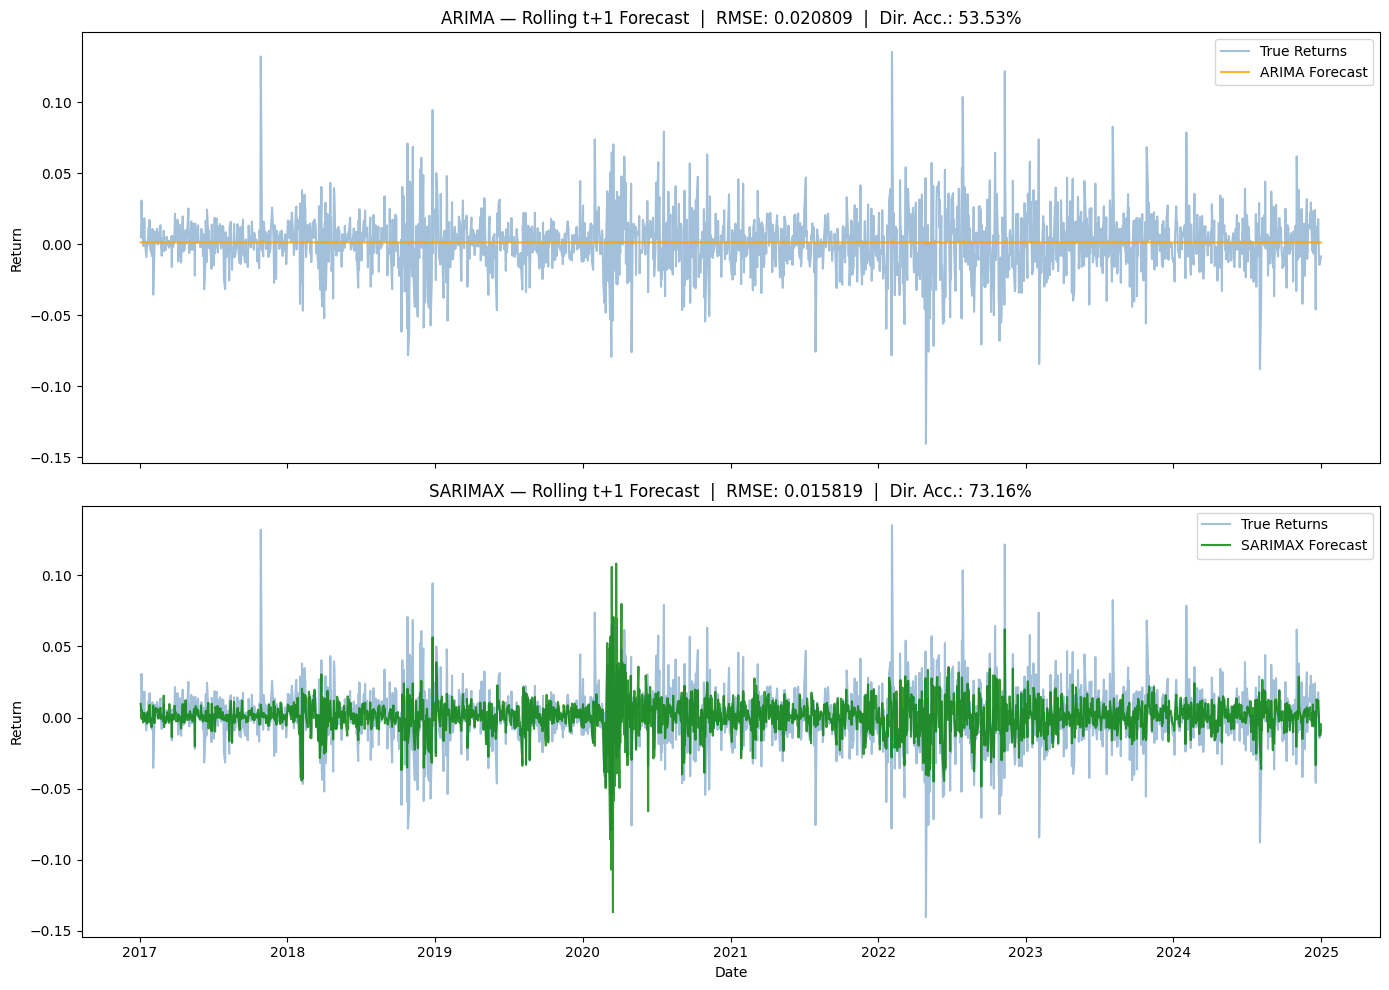

In [114]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

axes[0].plot(y_test.index, y_test,               label="True Returns",    alpha=0.5, color="steelblue")
axes[0].plot(arima_forecast.index, arima_forecast, label="ARIMA Forecast", alpha=0.8, color="orange")
axes[0].set_title(f"ARIMA — Rolling t+1 Forecast  |  RMSE: {r1['RMSE']}  |  Dir. Acc.: {r1['Directional Acc. (%)']}%")
axes[0].set_ylabel("Return")
axes[0].legend()

axes[1].plot(y_test.index, y_test,                     label="True Returns",      alpha=0.5, color="steelblue")
axes[1].plot(sarimax_forecast.index, sarimax_forecast, label="SARIMAX Forecast",  alpha=0.8, color="green")
axes[1].set_title(f"SARIMAX — Rolling t+1 Forecast  |  RMSE: {r2['RMSE']}  |  Dir. Acc.: {r2['Directional Acc. (%)']}%")
axes[1].set_ylabel("Return")
axes[1].set_xlabel("Date")
axes[1].legend()

plt.tight_layout()
plt.show()

Visual inspection confirms that ARIMA produces near-constant forecasts due to weak autocorrelation in returns. In contrast, SARIMAX captures market-driven fluctuations by incorporating S&P 500 returns as an exogenous variable.

Quantitatively, SARIMAX reduces out-of-sample RMSE by approximately 24%, demonstrating the predictive relevance of broader market movements.

### Price Reconstruction from Forecasted Returns

To visualize forecast quality in price space, we reconstruct the predicted price path by compounding the forecasted returns from the last known training price.

$$P_t = P_{t-1} \times (1 + \hat{r}_t)$$

This is purely illustrative — the goal is not to forecast long-horizon prices, but to understand how return forecast errors compound over time.

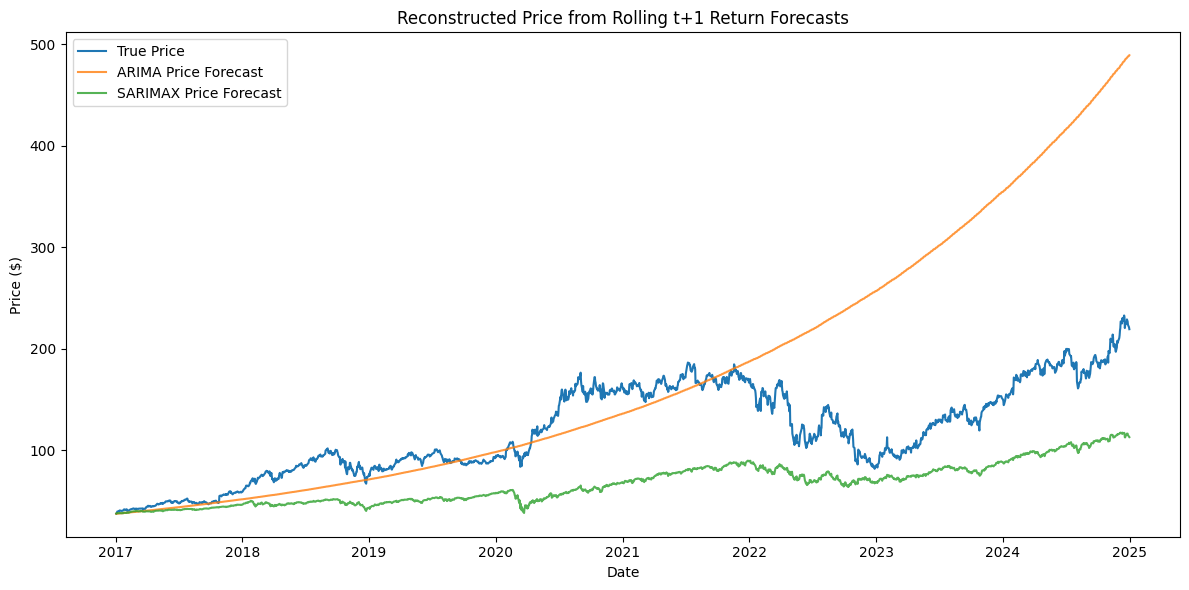

In [115]:
last_train_price = data.loc[data.index < split_date, "Price"].iloc[-1]

price_pred_arima, price_pred_sarimax = [], []
p_arima = p_sarimax = last_train_price

for r_arima, r_sarimax in zip(arima_forecast, sarimax_forecast):
    p_arima   = p_arima   * (1 + r_arima)
    p_sarimax = p_sarimax * (1 + r_sarimax)
    price_pred_arima.append(p_arima)
    price_pred_sarimax.append(p_sarimax)

price_pred_arima   = pd.Series(price_pred_arima,   index=y_test.index)
price_pred_sarimax = pd.Series(price_pred_sarimax, index=y_test.index)

plt.figure(figsize=(12, 6))
plt.plot(data.loc[data.index >= split_date, "Price"], label="True Price",           linewidth=1.5)
plt.plot(price_pred_arima,                            label="ARIMA Price Forecast",   alpha=0.8)
plt.plot(price_pred_sarimax,                          label="SARIMAX Price Forecast", alpha=0.8)
plt.legend()
plt.title("Reconstructed Price from Rolling t+1 Return Forecasts")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.tight_layout()
plt.show()

The price reconstruction highlights the compounding nature of forecast errors. Even small biases in predicted returns accumulate exponentially over time, leading to large deviations from the true price path. This reinforces the well-documented difficulty of long-horizon price prediction in financial markets.

## 6. Volatility Modeling — GARCH(1,1)

While ARIMA and SARIMAX focus on modeling the conditional mean of returns, financial time series are primarily characterized by time-varying volatility rather than predictable average returns.

Previous analysis of squared returns revealed strong and persistent autocorrelation, indicating the presence of volatility clustering. To capture this behavior, we implement a **GARCH(1,1)** model, which models the conditional variance of returns as:

$$\sigma_t^2 = \omega + \alpha \varepsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

Where:
- $\alpha$ captures short-term volatility shocks (ARCH effect),
- $\beta$ captures volatility persistence (GARCH effect).

If $\alpha + \beta \approx 1$, volatility is highly persistent — a common feature of equity markets.

The objective of this section is to:
- Estimate conditional volatility dynamics,
- Produce a rolling one-step-ahead volatility forecast on the test set,
- Evaluate GARCH performance against realized volatility,
- Confirm whether volatility is more predictable than returns.

In [116]:
from arch import arch_model

# Fit GARCH(1,1) on training returns (scaled by 100 for numerical stability)
garch_fit = arch_model(y_train * 100, vol="Garch", p=1, q=1, mean="Constant").fit(disp="off")

print(garch_fit.summary())

alpha = garch_fit.params["alpha[1]"]
beta  = garch_fit.params["beta[1]"]
print(f"\nα + β = {alpha + beta:.4f} (volatility persistence)")

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6975.16
Distribution:                  Normal   AIC:                           13958.3
Method:            Maximum Likelihood   BIC:                           13982.3
                                        No. Observations:                 3000
Date:                Sat, Feb 28 2026   Df Residuals:                     2999
Time:                        23:33:28   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1737  4.726e-02      3.675  2.379e-04 [8.106e-0

The GARCH(1,1) parameter estimates confirm strong volatility persistence: α + β is close to 1, meaning that volatility shocks decay slowly over time. This is consistent with the volatility clustering observed in the EDA.

### GARCH — Rolling t+1 Volatility Forecast

We produce a rolling one-step-ahead volatility forecast. For GARCH, the `arch` library does not have an `.apply()` equivalent, so we use a loop. However, the GARCH re-fit is much faster per iteration than ARIMA.

**Note:** This loop may take a few minutes to run.

In [117]:
returns_scaled = data["Return"] * 100
train_garch    = returns_scaled[returns_scaled.index < split_date]
test_garch     = returns_scaled[returns_scaled.index >= split_date]

rolling_vol   = []
history_garch = train_garch.copy()

for t in range(len(test_garch)):
    model    = arch_model(history_garch, vol="Garch", p=1, q=1, mean="Constant")
    res      = model.fit(disp="off")
    forecast = res.forecast(horizon=1)
    vol      = np.sqrt(forecast.variance.values[-1, 0])
    rolling_vol.append(vol)
    history_garch = pd.concat([history_garch, test_garch.iloc[t:t+1]])

rolling_vol = pd.Series(rolling_vol, index=test_garch.index, name="GARCH_Vol_Forecast")
print("GARCH rolling forecast complete.")

GARCH rolling forecast complete.


### GARCH — Evaluation vs Realized Volatility

We evaluate the GARCH forecast against **realized volatility**, defined as the 20-day rolling standard deviation of returns.

In [118]:
realized_vol = test_garch.rolling(20).std().dropna()

common_idx = realized_vol.index.intersection(rolling_vol.index)
rv = realized_vol.loc[common_idx]
gv = rolling_vol.loc[common_idx]

rmse_garch = np.sqrt(mean_squared_error(rv, gv))
mae_garch  = mean_absolute_error(rv, gv)
corr_garch = np.corrcoef(rv, gv)[0, 1]

print(f"GARCH Volatility Forecast — RMSE: {rmse_garch:.4f} | MAE: {mae_garch:.4f} | Corr: {corr_garch:.4f}")

GARCH Volatility Forecast — RMSE: 0.6080 | MAE: 0.5225 | Corr: 0.8459


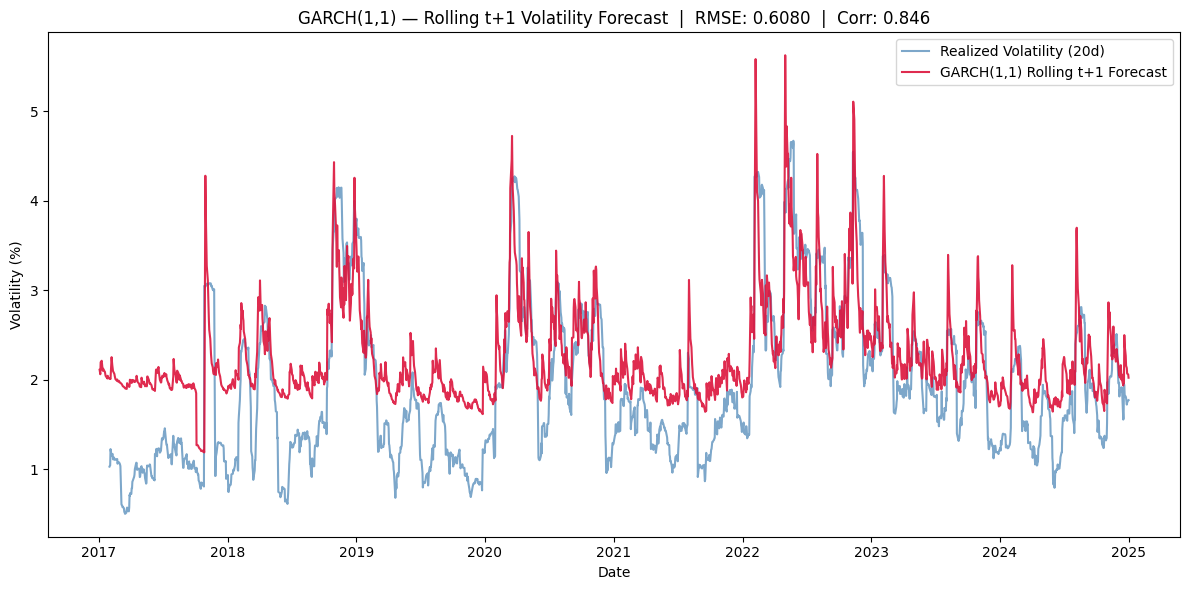

In [119]:
plt.figure(figsize=(12, 6))
plt.plot(realized_vol.index, realized_vol, label="Realized Volatility (20d)",      alpha=0.7, color="steelblue")
plt.plot(rolling_vol.index,  rolling_vol,  label="GARCH(1,1) Rolling t+1 Forecast", alpha=0.9, color="crimson")
plt.legend()
plt.title(f"GARCH(1,1) — Rolling t+1 Volatility Forecast  |  RMSE: {rmse_garch:.4f}  |  Corr: {corr_garch:.3f}")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.tight_layout()
plt.show()

The rolling GARCH(1,1) forecast successfully captures time-varying volatility dynamics. The model responds to periods of market stress (e.g., COVID crash in 2020, rate hike sell-off in 2022) and adjusts downward during calmer regimes, confirming strong volatility persistence.

This result contrasts with return predictability, reinforcing the well-established financial insight that **volatility is more predictable than returns**.

## 7. Save Forecasts

We save all rolling t+1 forecasts to a CSV file for use in Notebook 3 (evaluation and plots).

In [120]:
forecasts = pd.DataFrame({
    "ARIMA_Forecast":    arima_forecast,
    "SARIMAX_Forecast":  sarimax_forecast,
    "GARCH_Vol_Forecast": rolling_vol
})

forecasts.to_csv("../data/forecasts.csv")
print(f"Forecasts saved: {forecasts.shape} → ../data/forecasts.csv")
display(forecasts.head())

Forecasts saved: (2012, 3) → ../data/forecasts.csv


,ARIMA_Forecast,SARIMAX_Forecast,GARCH_Vol_Forecast
Date,,,
2017-01-03,0.001279,0.009601,2.109354
2017-01-04,0.001309,0.006504,2.082748
2017-01-05,0.001302,-0.000860,2.059667
2017-01-06,0.001515,0.005103,2.193502
2017-01-09,0.001401,-0.003494,2.210473


## Conclusion

In this notebook, we developed and evaluated three time-series models for Amazon stock using a consistent **rolling t+1 forecast** strategy:

- **ARIMA(1,0,1)** served as a univariate baseline. As expected from the EDA, it produced near-constant forecasts due to the absence of significant autocorrelation in daily returns.

- **SARIMAX(1,0,1)** with S&P 500 returns as an exogenous variable significantly improved performance, confirming that broad market movements carry predictive information for Amazon returns.

- **GARCH(1,1)** successfully modeled time-varying conditional volatility. With α + β ≈ 1, the model confirmed strong volatility persistence, and the rolling forecast tracked realized volatility dynamics through stress periods.

Key takeaway: **returns are largely unpredictable in their direction, but volatility is structurally persistent and forecastable**.

**Next step: Evaluation & Plots (Notebook 4).**